# Problem Set 1 - KNN
## CSCI 5622 - Fall 2021

For today's assignment, we will be implementing our own K-Nearest Neighbors (KNN) algorithm.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neighbors
import sklearn.datasets
import math
import random

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*

Yes - but it also has a ton of helper functions, including a dataset we'll be using later. But first, let's also create a dataset to play with and start working to build out our own classifier.

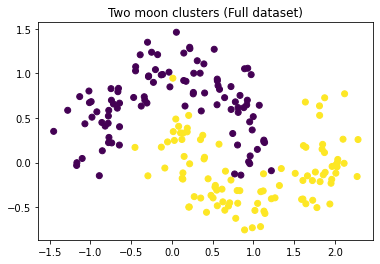

In [2]:
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.19, random_state=42) 
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]
plt.title("Two moon clusters (Full dataset)")
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

We have data!

Now, let's set up a KNNClassifier class. 

The KNNClassifier class will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- Fit the classifier using the training data
- Predict the class of new points `X_test`

We've written out a lot of the structure for you so it will be consistent and we can use / reuse it, and you can focus on the "important" stuff that actually relates to the machine learning itself.

In [3]:

class KNNClassifier:

    def __init__(self, k = 5):
        """
        Initialize our custom KNN classifier
        PARAMETERS

        k - the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._model = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.counts = 0

    def fit(self, features, labels):
        """
        
        :param features: 2-D np.array of shape (number training samples, features dimension)
        :param labels: 1-D np.array of shape (number training samples,)
        :return: self
        """
        
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels
        self.counts = self.get_counts()
        # Should be used to map the classes to {0,1,..C-1} where C is the number of classes
        self.label_to_index = dict(zip(sorted(self.counts.keys()), range(len(self.counts))))
        self.index_to_label = dict(zip(range(len(self.counts)), sorted(self.counts.keys())))
        return self

    def get_counts(self):
        """
        Creates a dictionary storing the count of elements of each class
        :return: dict where the keys are the classes and values are the counts
        """

        counts = dict()
        #BEGIN Workspace 1.1
        # Modify and/or add to counts so that it returns a count of each answer class found in y
        for class_label in set(self._y):
          counts[class_label] = list(self._y).count(class_label)
        #END Workspace 1.1
        return counts

    def majority_vote(self, indices):
        """
        Given indices, report the majority label of those points.
        FOR A TIE, report the most common label in the data set.
        :param indices: indices of training neighbors of shape (M, k) where k the classifier parameter
        :return: The majority label for each set of indices, shape (M,)
        """

        labels = None
        #BEGIN Workspace 1.2
        # TODO: Determine majority, assign it to label
        label_list = []
        for row in indices:
          cur_label = self._get_label(row)
          label_list.append(cur_label)
        
        labels = np.array(label_list)
        #END Workspace 1.2
        return labels

    def predict(self, points):
        """
        Given new data points, classify then according to the training data provided in fit and number of neighbors k
        :param point: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """

        answer = []
        #BEGIN Workspace 1.3
        # perform classification of points here
        (_, indices) = self._model.query(points, self._k)
        answer = self.majority_vote(indices)
        #END Workspace 1.3
        return answer

    def confusion_matrix(self, features_test, labels_test):
        """
        Generate the confusion matrix for the given test data
        :param features_test: an np.array of feature vectors of test points, shape (N, n_features)
        :param labels_test: he corresponding correct classes of our test set, shape (N,)
        :return: an C*C np.array of counts, where C is the number of classes in our classifier
        """
        C = len(self.counts)
        c_matrix = np.zeros((C, C))
        
        #BEGIN Workspace 1.4
        # Run classification for the test set, compare to test answers, and add counts to matrix
        predictions = self.predict(features_test)

        for actual_label, predicted_label in zip(labels_test, predictions):
          row_index = self.label_to_index[actual_label]
          col_index = self.label_to_index[predicted_label]
          c_matrix[row_index][col_index] += 1

        #END Workspace 1.4
        return c_matrix

    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        # score = 0
        # BEGIN Workspace 1.5
        # Compute accuracy of the classification of X_test
        c_matrix = self.confusion_matrix(features_test, labels_test)
        # Diagonal elements have the correct prediction
        # Accuracy = Correctly Predicted/ Total sample size
        score = c_matrix.diagonal().sum() / len(labels_test)
        #END Workspace 1.5
        return score

    # Helper methods
    def _get_label(self, neighbors):
      """
      Returns label by taking majority vote among neighbors
      """
      # Label count
      label_freq = dict()

      # Iterate and get labels
      for index in neighbors:
        cur_label = self._y[index]
        label_freq[cur_label] = label_freq.get(cur_label, 0)+1

      max_freq = max(label_freq.values())
      candidates = [label for label,freq in label_freq.items() if freq==max_freq]
      
      winner = None
      if len(candidates)>1:
        # Resolve TIE
        candidates_counts = {k: v for k,v in self.counts.items() if k in candidates}
        (most_common_label, _) = max(candidates_counts.items(), key=lambda k: k[1])
        winner = [label for label in candidates if label==most_common_label][0]
      else:
         winner = candidates[0]
      
      return winner
      


In [4]:
# # Rough work
# knn_classifier = KNNClassifier()
# knn_classifier.fit(X_train, y_train)
# knn_classifier._model.data
# type(knn_classifier.counts[0])
# x = knn_classifier.get_counts()
# result = knn_classifier.predict(X_test)
# knn_classifier.confusion_matrix(X_test, y_test).diagonal().sum()
# # list(y_test).count(1)
# # (result.count(0), result.count(1))
# # (list(y_test).count(0), list(y_test).count(1))
# knn_classifier.accuracy(X_test, y_test)

*But professor, this code isn't complete!*

### Problem 1: Complete our KNN Classifier - 25 Points

1.1 - Complete the `get_counts` function to return the count of each class found in the training set (5 points)

1.2 - Complete the `majority_vote` function to determine the majority class of a series of neighbors (5 points)

1.3 - Complete the `predict` function to capture the predicted class of a new datapoint (5 points)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.4 - Complete the `confusion_matrix` function to reveal the results of classification (5 points)

1.5 - Complete the `accuracy` function to get accuracy of the classifier based on a given test data (5 points)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

In [5]:
def show_decision_surface(model):
    """
    Helper function to visualize the decision surface of model
    :param model: Initialized KNNClassifier
    :return: None
    """
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    x_grid = np.arange(x_min, x_max, 0.1)
    y_grid = np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1,1), yy.reshape(-1,1)
    grid = np.hstack((r1,r2))
    y_hat = model.predict(grid)
    zz = y_hat.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='PiYG')
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

1.6. Try different values of k and report their accuracies and confusion matrices on the test set. Make sure to keep `random_state=42` so that the reported values don't change when code is re-run (5 points)

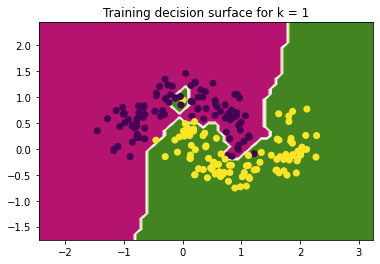

In [6]:
#BEGIN Workspace 1.6
#TODO: Try different Ks        
kk = 1
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
#END Workspace 1.6

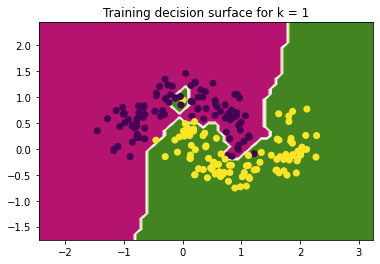

Confusion Matrix for (k=1):  [[44.  5.]
 [ 3. 48.]]
Accuracy for (k=1):  0.92


In [7]:
# Code for 1.6
# For k = 1
kk = 1
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

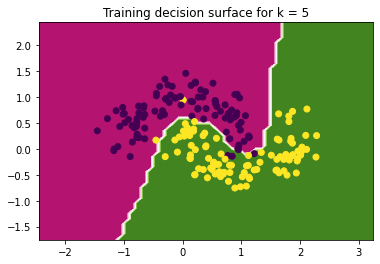

Confusion Matrix for (k=5):  [[47.  2.]
 [ 1. 50.]]
Accuracy for (k=5):  0.97


In [8]:
# Code for 1.6
# For k = 5
kk = 5
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

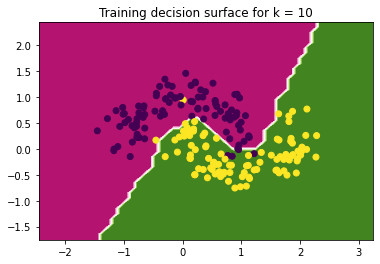

Confusion Matrix for (k=10):  [[47.  2.]
 [ 1. 50.]]
Accuracy for (k=10):  0.97


In [9]:
# Code for 1.6
# For k = 10
kk = 10
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

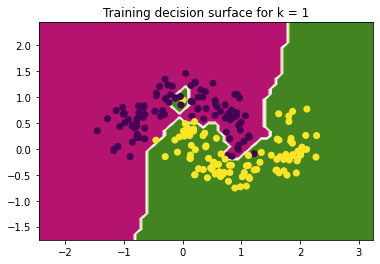

Confusion Matrix for (k=1):  [[44.  5.]
 [ 3. 48.]]
Accuracy for (k=1):  0.92


In [10]:
# Code for 1.6
# For k = 4
kk = 1
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

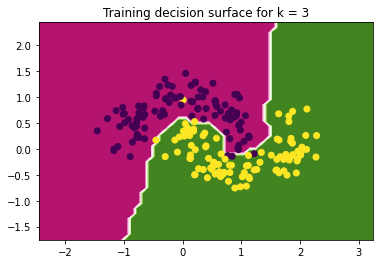

Confusion Matrix for (k=3):  [[47.  2.]
 [ 2. 49.]]
Accuracy for (k=3):  0.96


In [11]:
# Code for 1.6
# For k = 3
kk = 3
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

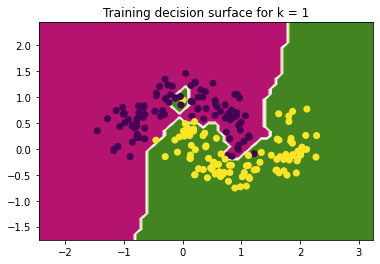

Confusion Matrix for (k=1):  [[44.  5.]
 [ 3. 48.]]
Accuracy for (k=1):  0.92


In [12]:
# Code for 1.6
# For k = 2
kk = 1
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

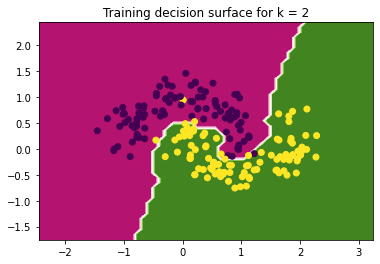

Confusion Matrix for (k=2):  [[48.  1.]
 [ 3. 48.]]
Accuracy for (k=2):  0.96


In [13]:
# Code for 1.6
# For k random experiment
kk = 2
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
c_matrix = model.confusion_matrix(X_test, y_test)
accuracy = model.accuracy(X_test, y_test)
print(f"Confusion Matrix for (k={kk}): ", c_matrix)
print(f"Accuracy for (k={kk}): ", accuracy)

#### Write up for 1.6 here

*   When the above algorithm is tested for k=1 we get an accuracy of 0.92. So we gradually increase k-values to test for the accuracy rates. 

*   When k=3 the algorithm gives accuracy of 0.96 but when k-value is made k=4 then the accuracy drops again to 0.92.

*   From k-values 5 to 10 the accuracy stays stable at 0.97

*   Starting from k-value 11 the accuracy starts dropping.


### Bonus (for the avid machine learner) (5 Points)
1.7. For which value of $k$ is the classifier consistent? (Only worry about this question within our `random_state=42` constraint)

1.8. Edit your `KNNClassifier` so that it's consistent for all $k$ (This solution should work beyond our `random_state=42` constraint, but retain the constraint when submitting your code above)

For a definition of a consistent classifier, refer to [Consistent Classification, Firm and Soft by Barum](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf) (The answer is found in the abstract and introduction sections of the paper) 

In [14]:
# Rough work
# X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.19) 
# X_train, y_train = X[:100], y[:100]
# X_test, y_test = X[100:], y[100:]
# plt.title("Two moon clusters (Full dataset)")

#### Write up for the bonus

1.7 With the random state as 42, the highest accuracy that the classifier gave is 0.97 for the k-values from 5 to 10. So in this range the algorithm behaves consistent.

1.8 In order to make KNN Classifier consistent across all values of K, we can make few modifications in calculating the majority vote of the K-neighbors. For this, we can use a data clustering algorithm like K-means (or) K-means++ (used idea of local separators from the paper above). We then define domain of indecision(consists points which are ambigous to classify). Now on taking majority vote we include only the valid neighbors (points which are not a part of indecision domain). By doing so, we can clearly avoid the ambigous neighbors which will make our KNN consistent.

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

Let's be a little smart about this - let's up some classes and helper functions to help us out.

### Problem 2: Implement KNN on Digits dataset - 25 Points

2.1 **Randomly** divide our digit dataset into training and testing sets (10 Points)

2.2 Report the number of examples in training and testing, as well as measuring then number of pixels in each image (5 points)

2.3 Create a confusion matrix of our classifier for K = 5 (10 points) *HINT: Doing this may cause you to catch mistakes in your classifier. Go fix those!*

In [15]:

class Numbers:
    def __init__(self):
        #load data from sklearn
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        self.labels = data["target"]
        self.features = features.reshape(features.shape[0], -1)
        
        # BEGIN Workspace 2.1 

        # - Divide our dataset into Train and Test datasets (80/20 split),
        #   replacing the variables above
        # - Initialize the classifier
        
        shuffled_features, shuffled_labels = self._shuffle_data()
        limit = math.ceil(shuffled_features.shape[0]*0.80)

        self.train_x = shuffled_features[0:limit]
        self.train_y = shuffled_labels[0:limit]
        self.test_x = shuffled_features[limit:]
        self.test_y = shuffled_labels[limit:]
        self._k = 5
        self.classifier = KNNClassifier(self._k)
      
        #END Workspace 2.1
        
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        #BEGIN Workspace 2.2
        # Create printouts for reporting the size of each set and the size of each datapoint

        print("Train Data Set (Features): ", np.shape(self.train_x))
        print("Train Data Set (Labels): ", np.shape(self.train_y))
        print("Test Data Set (Features): ", np.shape(self.test_x))
        print("Test Data Set (Labels): ", np.shape(self.test_y))
        num_rows, num_cols = self.train_x.shape
        print(f"Number of pixels for each data point is: {num_cols}")
        
        #END Workspace 2.2
        

    def classify(self):
        """
        Fits classifier using the training data and generate a confusion matrix for the test data
        then return the confusion matrix
        """
        #BEGIN Workspace 2.3.a
        # Create classifier from training data, generate confusion matrix for test data
        # self.classifier.fit
        self.classifier.fit(self.train_x, self.train_y)
        c_matrix = self.classifier.confusion_matrix(self.test_x, self.test_y)
        #END Workspace 2.3.a

        return  c_matrix
        
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = 0
        #BEGIN Workspace 2.3.b
        #TODO: Compute accuracy using confusion matrix
        accuracy = c_matrix.diagonal().sum()/len(self.test_y)
        #END Workspace 2.3.b
        
        return accuracy

    def view_digit(self, index):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        #TODO: process digit_image to matrix "image"
        digit_image = self.features[index]
        image = digit_image.reshape(8, -1)
        print("Image for digit {} for index {}".format(self.labels[index], index))
        plt.matshow(image)
        plt.show()
    
    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()

    # Helper methods
    def _shuffle_data(self):
      """
      Randomly shuffle the input data
      Returns:
        A tuple of shuffled features and labels
      """
      zipped_list = list(zip(self.features, self.labels))
      # Note: We can maintain random state here by seeding if needed
      # random.seed(10)
      random.shuffle(zipped_list)
      shuffled_feat, shuffled_labels = zip(*zipped_list)
      shuffled_feat = np.array(shuffled_feat)
      shuffled_labels = np.array(shuffled_labels)
      return shuffled_feat, shuffled_labels

    def modify_k_and_reinitialize(self, newK):
      """
      Modifies the K value and the train the KNN classifier.
      """
      self._k = newK
      self.classifier = KNNClassifier(self._k)
        

In [16]:
# Rough work
# import random
# data = sklearn.datasets.load_digits()
# features = data['data']
# # print(data['data'])
# # print("Original Shape", np.shape(data['data']))
# features.reshape(features.shape[0], -1)
# # print("Modified Shape", np.shape(features))
# # print(features)
# # print(math.ceil(features.shape[0]*.80))
# # limit = math.ceil(features.shape[0]*.80)
# labels = data['target']
# # train_x = features[:limit]
# # train_y = labels[:limit]
# # test_x = features[limit:]
# # test_y = labels[limit:]
# # print(np.shape(train_x), np.shape(test_x), np.shape(train_y), np.shape(test_y))
# # print(np.shape(train_x[0]))
# # _, num_cols = train_x.shape
# # print("Num cols: ", num_cols)
# zipped = list(zip(features, labels))
# random.shuffle(zipped)
# shuffled_features, shuffled_labels = zip(*zipped)
# print(np.shape(shuffled_features), np.shape(shuffled_labels))

Train Data Set (Features):  (1438, 64)
Train Data Set (Labels):  (1438,)
Test Data Set (Features):  (359, 64)
Test Data Set (Labels):  (359,)
Number of pixels for each data point is: 64
Image for digit 0 for index 10


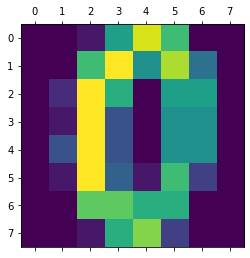

In [17]:
numbers = Numbers()
numbers.report()
numbers.view_digit(10)

In [18]:
numbers.accuracy()

0.9888579387186629

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore that issue a little further by turning the $K$ and random split knobs

### Problem 3: Improving KNN on Digits - 20 Points

3.1 Determine which classes are most often confused (from our confusion matrix above), inspect some examples of these digits (using the `view_digit` function in our Numbers class), and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (10 pts)

3.2 Explore the influence of the number of nearest neighbors (i.e. try changing our K). Plot the relationship between K and accuracy, and write a brief (4 - 5 sentences) description of how this factor impacts our accuracy. To mitigate the effect of randomness from the split, you have to run the evaluation multiple times and report the mean accuracy. Make sure the runs for different Ks are done on the same splits. (5 pts)

3.3 Explore the influence of the train / test split of our data (i.e. copy our Numbers class into Numbers2 below and try changing the split for our dataset). Plot the relationship between the split % and accuracy, and write a brief (4 - 5 sentences) description of its impact. (5 pts)

You can complete the `NumbersKnobs` class and use it as you see fit. But it's only necessary for 3.3

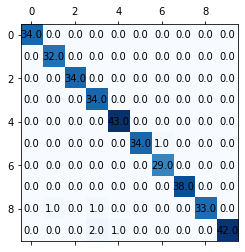

In [19]:
#BEGIN 3.1a
#Print out problem class images
numbers = Numbers()
c_matrix = numbers.classify()
Numbers.display_confusion(c_matrix)
#END 3.1a

Number 8 misclassified as 1 (possible images from above observation): 
Image for digit 8 for index 18


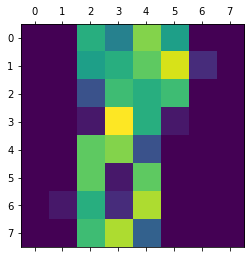

Image for digit 8 for index 122


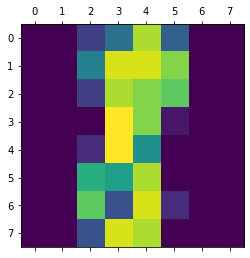

Image for digit 8 for index 1279


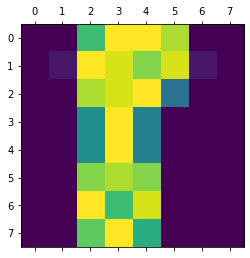

Image for digit 8 for index 1327


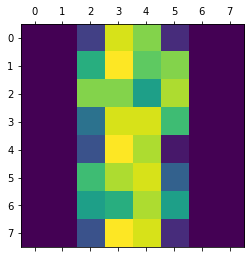

Image for digit 8 for index 1790


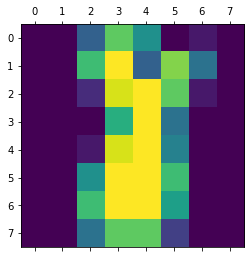

Number 8 misclassified as 3 (possible images from above observation): 
Image for digit 8 for index 1280


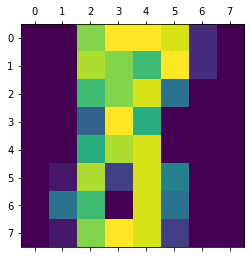

Image for digit 8 for index 1423


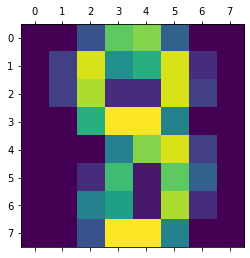

Image for digit 8 for index 1537


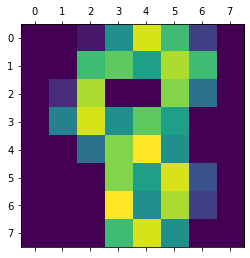

[None, None, None]

In [20]:
# 3.1a Continued..
# Number '8' is often misclassified as '1' or '3'
# Running below code displays all 8's from the features. Get indices of possible images for misclassification from running this.
# [numbers.view_digit(idx) for idx,(x,y) in enumerate(zip(numbers.features, numbers.labels)) if y==8] 
print("Number 8 misclassified as 1 (possible images from above observation): ")
[numbers.view_digit(idx) for idx, _ in enumerate(numbers.features) if idx in [18, 122, 1279, 1327, 1790]] 
print("Number 8 misclassified as 3 (possible images from above observation): ")
[numbers.view_digit(idx) for idx, _ in enumerate(numbers.features) if idx in [1280, 1423, 1537]] 

Number 9 misclassified as 5 (possible images from above observation): 
Image for digit 9 for index 9


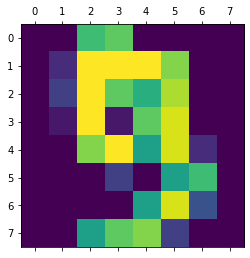

Image for digit 9 for index 203


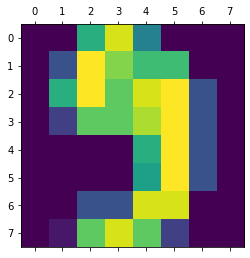

Image for digit 9 for index 1006


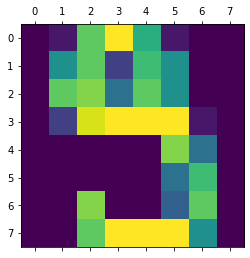

Image for digit 9 for index 1379


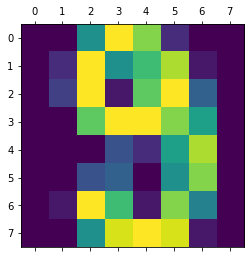

Number 9 misclassified as 1 (possible images from above observation): 
Image for digit 9 for index 677


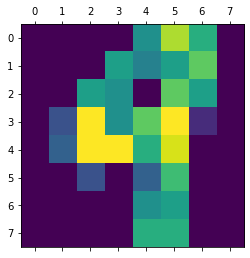

Image for digit 9 for index 683


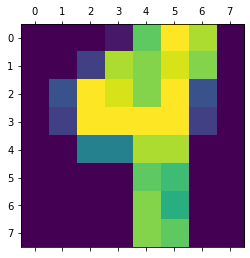

Number 9 misclassified as 4 (possible images from above observation): 
Image for digit 9 for index 1792


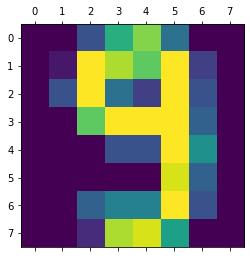

[None]

In [21]:
# 3.1a Continued..
# Number '9' is often misclassified as '1' or '5' or '4'
# Running below code displays all 9's from the features. Get indices of possible images for misclassification from running this.
# [numbers.view_digit(idx) for idx,(x,y) in enumerate(zip(numbers.features, numbers.labels)) if y==9]
print("Number 9 misclassified as 5 (possible images from above observation): ")
[numbers.view_digit(idx) for idx, _ in enumerate(numbers.features) if idx in [9, 203, 1006, 1379]] 
print("Number 9 misclassified as 1 (possible images from above observation): ")
[numbers.view_digit(idx) for idx, _ in enumerate(numbers.features) if idx in [677, 683]]
print("Number 9 misclassified as 4 (possible images from above observation): ")
[numbers.view_digit(idx) for idx, _ in enumerate(numbers.features) if idx in [1792]]

### **3.1b. Description of mis-classification:**

**Case 1**: Number 8 misclassified as 1 (or) 3

1. On generating the confusion matrix for multiple iterations, I was able to observe that the number 8 is most often misclassified as either 1 or 3.

2. On inspecting the images for the digit 8, for few images the pixels were cluttered that it resembles either 1 or 3. 

* 8 as 1 indices : [18, 122, 1279, 1327, 1790]
* 8 as 3 indices : [1280, 1423, 1537]

**Case 2**: Number 9 misclassified as 5 (or) 4 (or) 1

Similarly, the digit 9 is misclassified as '5' or '4' or '1'

* 9 as 5 indices: [9, 203, 1006, 1379]
* 9 as 1 indices: [677, 683]
* 9 as 4 indices: [1792]

**Findings**: 

The possible reasons that I can think of for these misclassifications are: 
1. The algorithm may need to train on more data for further more accurate classification of the numbers.

2. In the given data set, the numbers may be wrongly classified (label is wrong) For example, for number 8 (index 1327, 1790) the image is more similar to 1 than 8.

3. OCR errors may also contribute to incorrect scanning and labelling of a particular number.

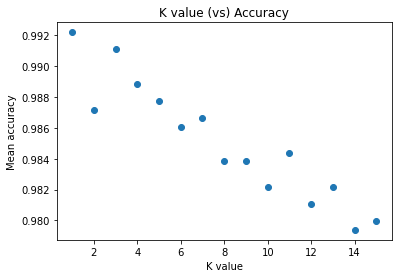

In [22]:
#BEGIN 3.2a
#TODO: Run evaluation for different K and plot K vs Accuracy

max_iterations = 5
k_values = range(1,16)
accuracy_map = {}

for iteration in range(max_iterations):
  # Initialize numbers and use it across multiple K values
  numbers = Numbers()

  # For a particular split in test and train check the accuracy for multiple K values
  for k in k_values:
    numbers.modify_k_and_reinitialize(k)
    accuracy = numbers.accuracy()
    accuracy_map[k] = accuracy_map.get(k, 0) + accuracy
  # end inner loop
# end outer loop

# Take the average of the accuracy obtained in the above loop
accuracy_map = {k : v/max_iterations for k, v in accuracy_map.items()}
plt.scatter(accuracy_map.keys(), accuracy_map.values())
plt.title("K value (vs) Accuracy")
plt.xlabel("K value")
plt.ylabel("Mean accuracy")
plt.show()

#END 3.2a

#### **3.2b Effect of K on classifier accuracy.**

* The above graph is plotted by taking the average mean obtained in 5 different iterations for K-value from 1 to 15. 

* From the above graph, I can observe that the accuracy drops with increase in K-value.  

* The highest accuracy is observed at K=1.

* If K value is very large (> number of data points of a particular label) then the accuracy will be very poor, because we consider neighbours exceeding the total number of values in train set for a particular label.

In [23]:

class NumbersKnobs(Numbers):
    """ 
    Inherits from Numbers, so feel free to use methods from Numbers
    """

    def __init__(self, k=5, train_ratio=0.8):
        #load data from sklearn
        self._k = k
        self.train_ratio = train_ratio
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        self.labels = data["target"]
        self.features = features.reshape(features.shape[0], -1)

        #BEGIN Workspace 3.3a
        shuffled_features, shuffled_labels = self._shuffle_data()
        limit = math.ceil(shuffled_features.shape[0]*self.train_ratio)

        self.train_x = shuffled_features[0:limit]
        self.train_y = shuffled_labels[0:limit]
        self.test_x = shuffled_features[limit:]
        self.test_y = shuffled_labels[limit:]
        self.classifier = KNNClassifier(self._k)
      
        #END Workspace 3.3a


0.5: 0,1,2,3,4,5,6,7,8,9,
0.6: 0,1,2,3,4,5,6,7,8,9,
0.7: 0,1,2,3,4,5,6,7,8,9,


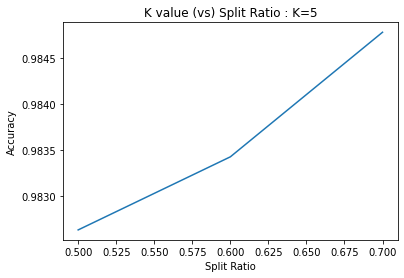

In [25]:
#BEGIN Workspace 3.3b
# analyze the effect of split ratio
k = 5
repetitions = 10 # Feel free to increase it
split_ratios = np.array([0.5, 0.6, 0.7])
results = np.zeros((len(split_ratios),repetitions))
for i, s in enumerate(split_ratios):
    print(s ,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersKnobs(k=k, train_ratio=s)
        results[i,j] = numbers.accuracy() # get accuracy of classification
    print("")

# Add title axis labels to the plot
plt.title(f"K value (vs) Split Ratio : K={k}")
plt.xlabel("Split Ratio")
plt.ylabel("Accuracy")
plt.plot(split_ratios, results.mean(1))

#END Workspace 3.3b

#### **3.3b Effect of varying the split ratio**

* In the above graph, we can observe the accuracy rate is comparatively low when train and test datasets are of equal sizes. So gradually as we increase the size of train set the accuracy rate also goes up. 

* This suggests that the model's accuracy increases when it trains on more data.

### Problem 4 : Improving KNN on MNIST using WeightedKNN (30 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point. Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote. Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
$$
where ${\cal N}_K(x)$ is the set of the closest $k$ neighbors to $x$


4.1 Complete the `fit` method in a similar way to `KNNClassifier` (5 pts)

4.2 Complete `majority_vote`: it's certainly possible that a query point could be distance $0$ away from some training example. If this happens your implementation should handle it and return the appropriate class label. (5 pts)

4.3 Complete `predict` (5 pts)

4.4 Compete `confusion_matrix` and `accuracy` methods (5 pts)

4.5 Compare `KNNClassifier` and `WeightedKNNClassifier` for multiple $K$, make sure that for each run both classifers are fitted using the same train/test split. You can execute multiple runs to mitigate the split randomness. Report for which K you get the best accuracy for each classifier and the best overall classifier. (10 pts)


In [26]:
class WeightedKNNClassifier:
    """
    Class to store data for regression problems 
    """
    def __init__(self, k, use_weighted_distance=True):
        """
        Creates a kNN instance
        :param k: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        self._k = k
        self._model = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.counts = {}
        
        # Boolean flag indicating whether to do distance weighting (if you want to make it versatile)
        self._use_weighted_distance = use_weighted_distance
        
    def fit(self, features, labels):
        
        # BEGIN Workspace 4.1
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels
        self.counts = self._get_counts()

        #END Workspace 4.1
        
        # Should be used to map set of classes to {0,1,..C-1} where C is the number of classes
        classes = list(set(list(labels)))
        self.label_to_index = dict(zip(sorted(classes), range(len(classes))))
        self.index_to_label = dict(zip(range(len(classes)), sorted(classes)))
        return self

    def majority_vote(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        # YOUR CODE HERE 
        #BEGIN Workspace 4.2
        label_list = []
        for (row, distances) in zip(neighbor_indices, neighbor_distances):
          # If flag is True we use weighted distance else fallback to normal KNN
          if self._use_weighted_distance:
            cur_label = self._get_label_weighted(row, distances)
          else:
            cur_label = self._get_label_counts(row)
          label_list.append(cur_label)
        
        labels = np.array(label_list)
        #END Workspace 4.2
        
        return labels
    
    def predict(self, features):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions

        :param features: an (m x p) dimension np.array of points to predict labels for
        """
        labels = None
      
        # BEGIN Workspace 4.3
        # predict labels

        (distances, indices) = self._model.query(features, self._k)
        labels = self.majority_vote(indices, distances)

        #END Workspace 4.3
        return labels

    def confusion_matrix(self, features_test, labels_test):
        """
        Generate a confusion matrix for the given test set
        PARAMETERS
        testX - an np.array of feature vectors of test points
        testY - the corresponding correct classifications of our test set
        RETURN
        C - an N*N np.array of counts, where N is the number of classes in our classifier
        """
        C = len(set(list(self._y)))
        c_matrix = np.zeros((C, C))
      
        #BEGIN Workspace 4.4.a
        # Run classification for the test set, compare to test answers, and add counts to matrix
        predictions = self.predict(features_test)

        for actual_label, predicted_label in zip(labels_test, predictions):
          row_index = self.label_to_index[actual_label]
          col_index = self.label_to_index[predicted_label]
          c_matrix[row_index][col_index] += 1
            
        #END Workspace 4.4.a
    
        return c_matrix
    
    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = 0
        #BEGIN Workspace 4.4.b
        #TODO: Compute accuracy of the classification of features_test
        c_matrix = self.confusion_matrix(features_test, labels_test)
        score = c_matrix.diagonal().sum()/len(labels_test)
        #END Workspace 4.4.b
        return score

    # Helper methods
    def _get_label_weighted(self, neighbors, distances):
      """
      Returns label by taking weighted Vote among neighbours
      """
      class_weights = {}
      
      for neighbor_index, distance in zip(neighbors, distances):
        cur_label = self._y[neighbor_index]
        # If distance is Zero we keep the weight as One.
        cur_weight = 1 if distance == 0 else 1/distance
        class_weights[cur_label] = class_weights.get(cur_label, 0) + cur_weight

      # Resolve Tie with Count
      # Get the max weight among neighbors.
      # If there are more than one one candidate then resolve based on neighbor count
      cur_labels = list(class_weights.keys())
      max_weight = max(class_weights.values())
      candidates = [label for label, value in class_weights.items() if value == max_weight]

      if len(candidates)>1: 
        candidates_counts = {k: v for k,v in self.counts.items() if k in candidates}
        (most_common_label, _) = max(candidates_counts.items(), key=lambda k: k[1])
        winner = [label for label in candidates if label==most_common_label][0]
      else: 
        winner = candidates[0]
      
      return winner

    def _get_label_counts(self, neighbors):
      """
      Returns label by taking majority vote among neighbors
      """
      # Label count
      label_freq = dict()

      # Iterate and get labels
      for index in neighbors:
        cur_label = self._y[index]
        label_freq[cur_label] = label_freq.get(cur_label, 0)+1

      max_freq = max(label_freq.values())
      candidates = [label for label,freq in label_freq.items() if freq==max_freq]
      
      winner = None
      if len(candidates)>1:
        # Resolve TIE
        candidates_counts = {k: v for k,v in self.counts.items() if k in candidates}
        (most_common_label, _) = max(candidates_counts.items(), key=lambda k: k[1])
        winner = [label for label in candidates if label==most_common_label][0]
      else:
         winner = candidates[0]
      
      return winner

    def _get_counts(self):
        """
        Creates a dictionary storing the count of elements of each class
        :return: dict where the keys are the classes and values are the counts
        """
        counts = dict()
        # Modify and/or add to counts so that it returns a count of each answer class found in y
        for class_label in set(self._y):
          counts[class_label] = list(self._y).count(class_label)
        return counts

In [27]:
class NumbersWeighted(NumbersKnobs):
    def __init__(self, k=5, train_ratio=0.8):
        super(NumbersWeighted, self).__init__(k, train_ratio)
        self.classifier = WeightedKNNClassifier(k=self._k)
        

In [29]:
#BEGIN Workspace 4.5
#TODO: Run multiple comparisons
repetitions = 25
ks = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 25, 32, 50] # Add more
results_simple = np.zeros((len(ks),repetitions))
results_weighted = np.zeros((len(ks),repetitions))

for i, k in enumerate(ks):
    print(k,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersWeighted(k=k)
        numbers.classifier.fit(numbers.train_x, numbers.train_y)
        results_weighted[i,j] = numbers.classifier.accuracy(numbers.test_x, numbers.test_y)
        numbers.classifier = KNNClassifier(k=numbers._k)
        numbers.classifier.fit(numbers.train_x, numbers.train_y)
        results_simple[i,j] =  numbers.classifier.accuracy(numbers.test_x, numbers.test_y)
    print("")

# Average results over multiple runs and report best classifier
simple_means = results_simple.mean(axis=1)
weighted_means = results_weighted.mean(axis=1)
print("K values:", ks)
print("Simple KNN Accuracy:", simple_means)
print("Weighted KNN Accuracy:", weighted_means)

1: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
2: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
3: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
4: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
9: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
10: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
11: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
12: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
13: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
25: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
32: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
50: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
K values: [1, 2, 3, 4, 5, 6

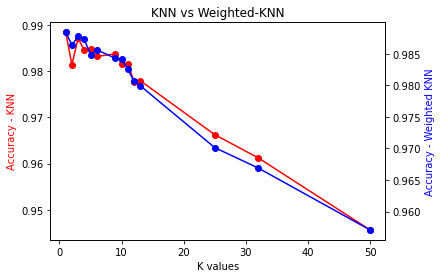

In [30]:
# Plot a graph for the accuracy of both classifiers
_, ax = plt.subplots()
ax.set_title("KNN vs Weighted-KNN")
ax.set_xlabel("K values")
ax.set_ylabel("Accuracy - KNN", color='red')
ax.plot(ks, simple_means, color='red', marker='o')
ax2 = ax.twinx()
ax2.set_ylabel("Accuracy - Weighted KNN", color='blue')
ax2.plot(ks, weighted_means, color='blue', marker='o')
plt.show()
#END Workspace 4.5

#### **4.5 Report best results per classifier and overall performance.**

(a) For KNN Classifier, by observing the accuracy for different values of K across several iterations, the algorithm gives maximum accuracy when K=1.

(b) For Weighted KNN classifier, on multiple repetitions(repetitions=15) the highest accuracy fluctuates between K=1 and K=2 on each cycle. Increasing the repetitions to 25, the highest accuracy occurs at K=1.

(c) Comparing KNN and Weighted KNN, the latter performs better. This can be observed from the above graph that for a given K value, the weighted KNN gives comparatively more accuracy than KNN classifier. Since we take into account, the closeness of the points in WeightedKNN, we are getting better accuracy compared to KNN which just takes the majority count among its neighbours.

#### Bonus (5 Points)
__4.6 Is `WeightedKNNClassifier` a consistent classifier? why or why not?__

*4.6 bonus response here*

* Weighted KNN will perform better for the query points along the decision surface, where it is possible that the K-nearest neighbors will be a mixed set from two or more classes. In such cases, majority vote might result in incorrect classification. So weighted KNN will work effectively as we consider closeness of the points.

* Weighted KNN will face issues when the data set has noise. Consider the following scenario when K=5 let's take a query point (Xq) for which there are two outliers nearby(at close proximity) and there are three valid neighbors (which are at comparatively farther distance). Now, weighted KNN will misclassify this point because of the closeness of the outliers but whereas KNN classifier will correctly classify because of the majority of valid neighbours. So in a data set which has lot of noise/ intermix of data points from different classes weighted KNN will give less accuracy.

* So if we can effectively handle such outliers, probably by cleaning the data set from noise before training, Weighted KNN is more consistent.